In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load the data
housing_df = pd.read_csv('../dataset/housing.csv')

In [3]:
# Display the first 5 rows of the dataset
housing_df.head(5)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [4]:
housing_df.info() # total_bedrooms has missing values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


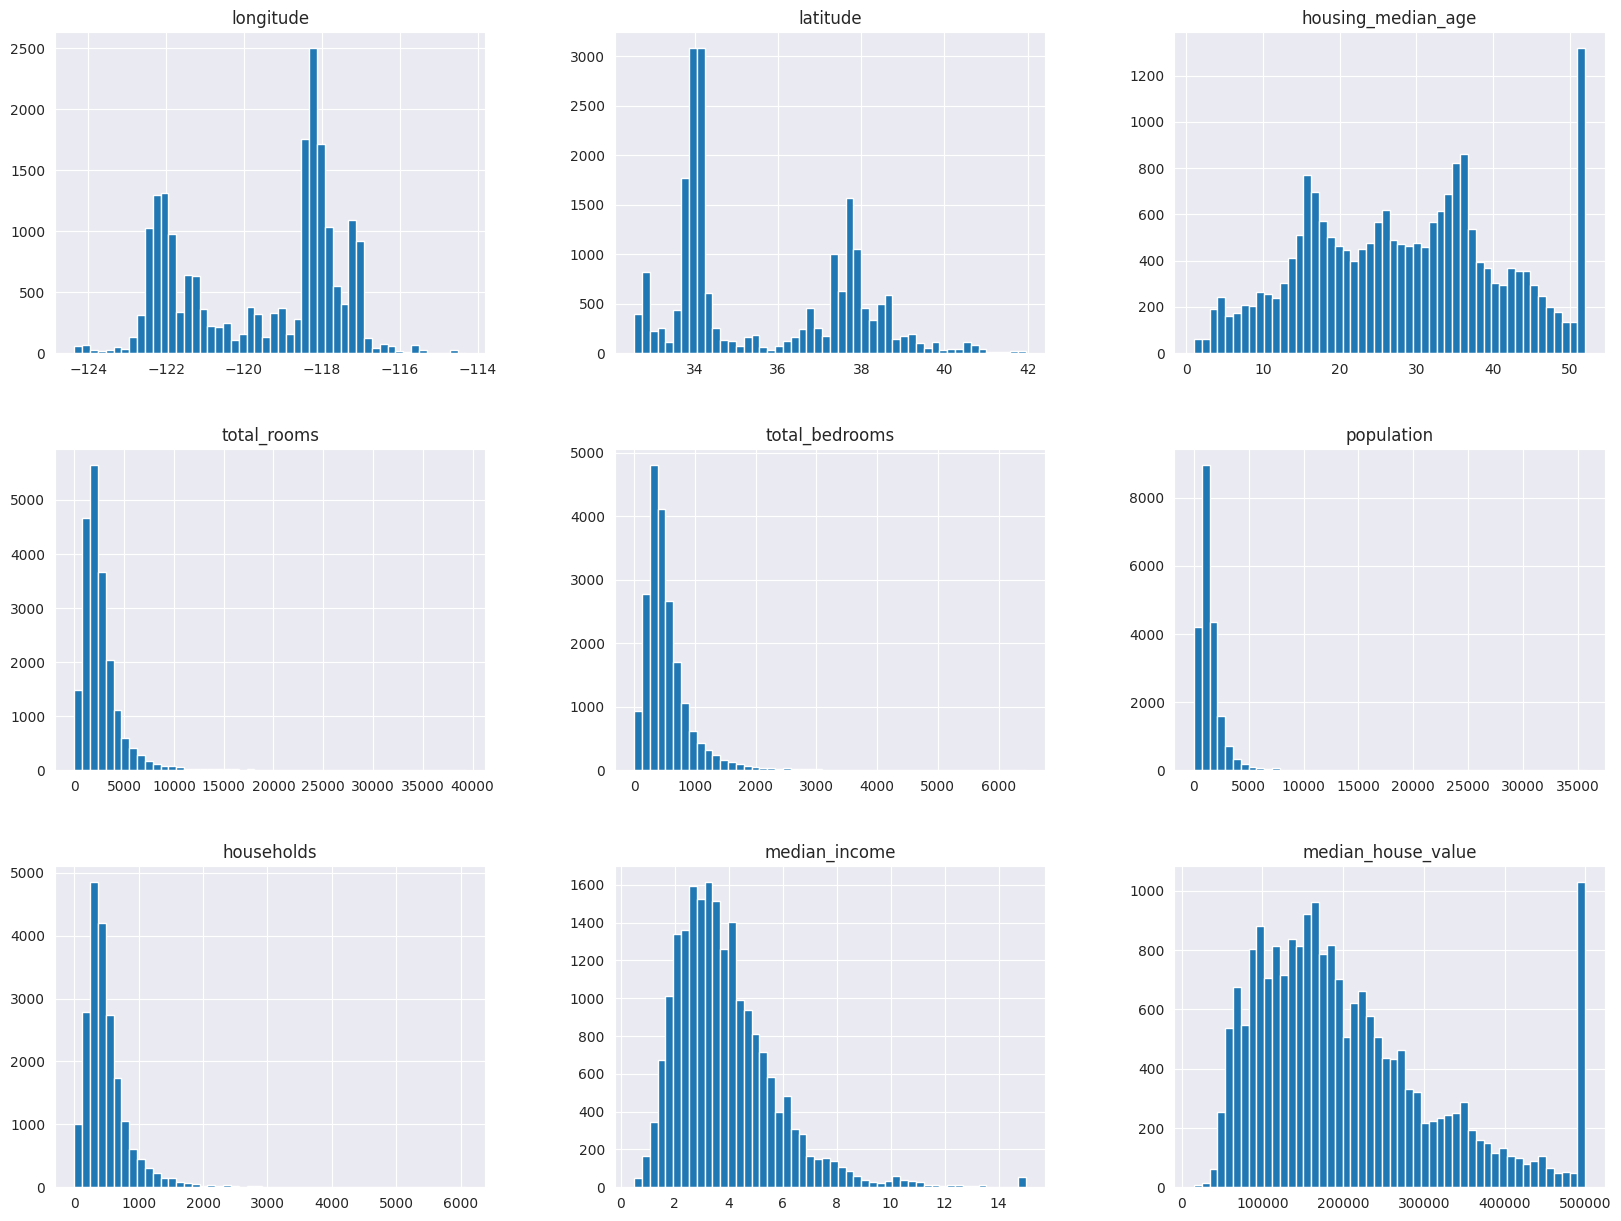

In [5]:
# creating histograms 
housing_df.hist(bins=50, figsize=(20,15))
plt.show()

In [6]:
# Splitting the data into training and testing sets

def split_train_test(data, test_ratio) -> tuple:
    """ 
    Split the data into training and testing sets
    data: the dataset to be split
    test_ratio: the ratio of the test set size to the total dataset size
    """
    np.random.seed(42) # to ensure that the same test set is generated each time
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

train_set, test_set = split_train_test(housing_df, 0.2) # 80% training and 20% testing

In [7]:
# hashed version of the split_train_test function

from zlib import crc32

def test_set_check(identifier, test_ratio):
    return crc32(np.int64(identifier)) & 0xffffffff < test_ratio * 2**32

def split_train_test_by_id(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

housing_df_with_id = housing_df.reset_index() # adds an 'index' column
housing_df_with_id['id'] = housing_df['longitude'] * 1000 + housing_df['latitude'] # creates a unique identifier
train_set, test_set = split_train_test_by_id(housing_df_with_id, 0.2, 'index')

In [8]:
# using the sklearn train_test_split function

from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing_df, test_size=0.2, random_state=42)


<Axes: >

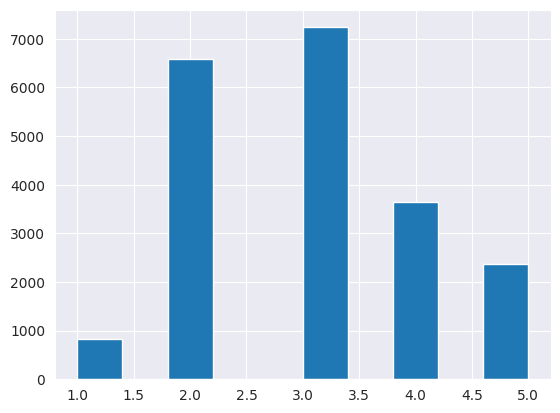

In [9]:
# Stratified sampling
housing_df['income_cat'] = pd.cut(housing_df['median_income'], # create an income category attribute
                                  bins=[0., 1.5, 3.0, 4.5, 6., np.inf], # income categories
                                  labels=[1, 2, 3, 4, 5]) # labels for the income categories

housing_df['income_cat'].hist() # income category histogram

In [10]:
# Stratified sampling using the income category
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in split.split(housing_df, housing_df['income_cat']):
    strat_train_set = housing_df.loc[train_index]
    strat_test_set = housing_df.loc[test_index]

In [11]:
# income category proportions in the test set
res = strat_test_set['income_cat'].value_counts() / len(strat_test_set)
res

income_cat
3    0.350533
2    0.318798
4    0.176357
5    0.114341
1    0.039971
Name: count, dtype: float64

In [12]:
# remove the income_cat attribute to return the data to its original state
for set_ in (strat_train_set, strat_test_set):
    set_.drop('income_cat', axis=1, inplace=True)

<Axes: xlabel='longitude', ylabel='latitude'>

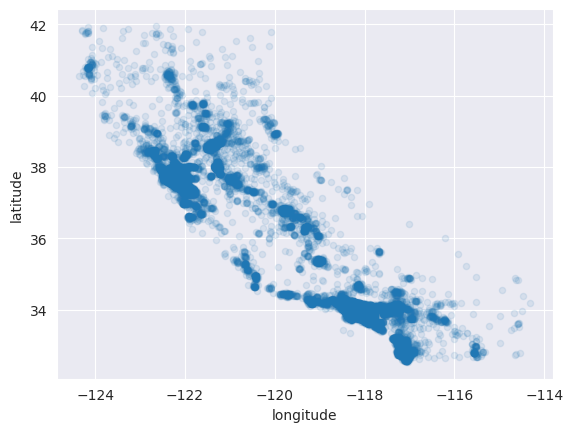

In [13]:
# Visualizing the data
housing = strat_train_set.copy()
housing.plot(kind='scatter', x='longitude', y='latitude', alpha=0.1) # alpha is used to visualize the density of the data points

<Axes: xlabel='longitude', ylabel='latitude'>

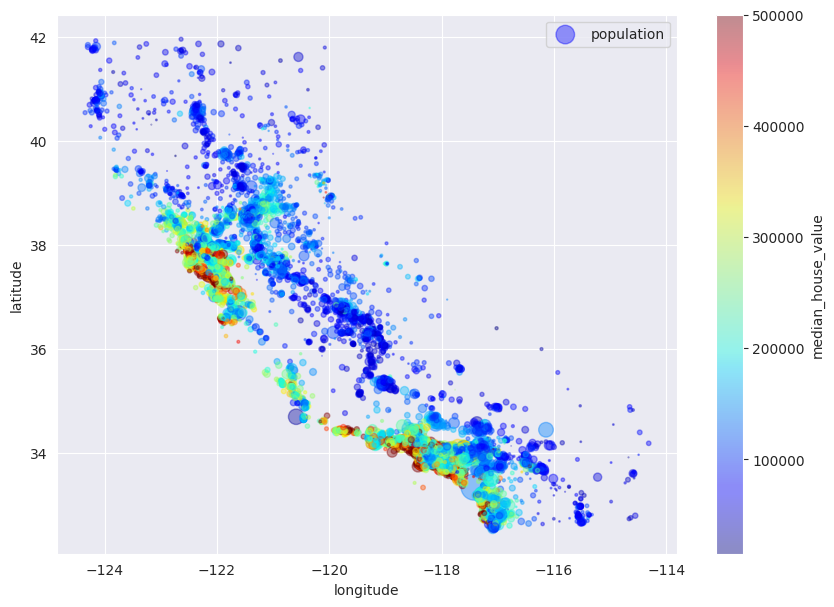

In [14]:
# colored by the housing prices
housing.plot(kind='scatter', # scatter plot
             x='longitude', # x-axis
             y='latitude', # y-axis
             alpha=0.4, # transparency
             s=housing['population']/100, # radius of each circle represents the district's population
             label='population', # legend label
             figsize=(10,7), # figure size
             c='median_house_value', # color represents the price
             cmap=plt.get_cmap('jet'), # color map
             colorbar=True) # color bar
# price of house very much related to the location and population density

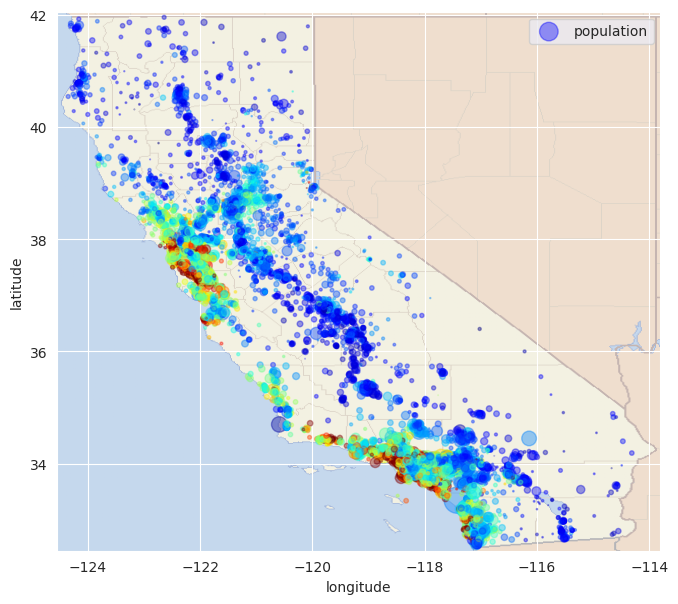

In [15]:
# colored map of california
import matplotlib.image as mpimg

california_img = mpimg.imread('images/california.png')

ax = housing.plot(kind='scatter', x='longitude', y='latitude', figsize=(10,7),
                    s=housing['population']/100, label='population',
                    c='median_house_value', cmap=plt.get_cmap('jet'),
                    colorbar=False, alpha=0.4)
plt.imshow(california_img, # image to be displayed
           extent=(-124.55, -113.80, 32.45, 42.05), # coordinates of the image
           alpha=0.5, # transparency
           cmap=plt.get_cmap('jet')) # color map


In [16]:
# Looking for correlations
housing_df['ocean_proximity'] = housing_df['ocean_proximity'].astype('category').cat.codes
corr_matrix = housing_df.corr()
res = corr_matrix['median_house_value'].sort_values(ascending=False)
res

median_house_value    1.000000
median_income         0.688075
income_cat            0.643892
total_rooms           0.134153
housing_median_age    0.105623
ocean_proximity       0.081750
households            0.065843
total_bedrooms        0.049686
population           -0.024650
longitude            -0.045967
latitude             -0.144160
Name: median_house_value, dtype: float64

array([[<Axes: xlabel='median_house_value', ylabel='median_house_value'>,
        <Axes: xlabel='median_income', ylabel='median_house_value'>,
        <Axes: xlabel='total_rooms', ylabel='median_house_value'>,
        <Axes: xlabel='housing_median_age', ylabel='median_house_value'>],
       [<Axes: xlabel='median_house_value', ylabel='median_income'>,
        <Axes: xlabel='median_income', ylabel='median_income'>,
        <Axes: xlabel='total_rooms', ylabel='median_income'>,
        <Axes: xlabel='housing_median_age', ylabel='median_income'>],
       [<Axes: xlabel='median_house_value', ylabel='total_rooms'>,
        <Axes: xlabel='median_income', ylabel='total_rooms'>,
        <Axes: xlabel='total_rooms', ylabel='total_rooms'>,
        <Axes: xlabel='housing_median_age', ylabel='total_rooms'>],
       [<Axes: xlabel='median_house_value', ylabel='housing_median_age'>,
        <Axes: xlabel='median_income', ylabel='housing_median_age'>,
        <Axes: xlabel='total_rooms', ylabel='housi

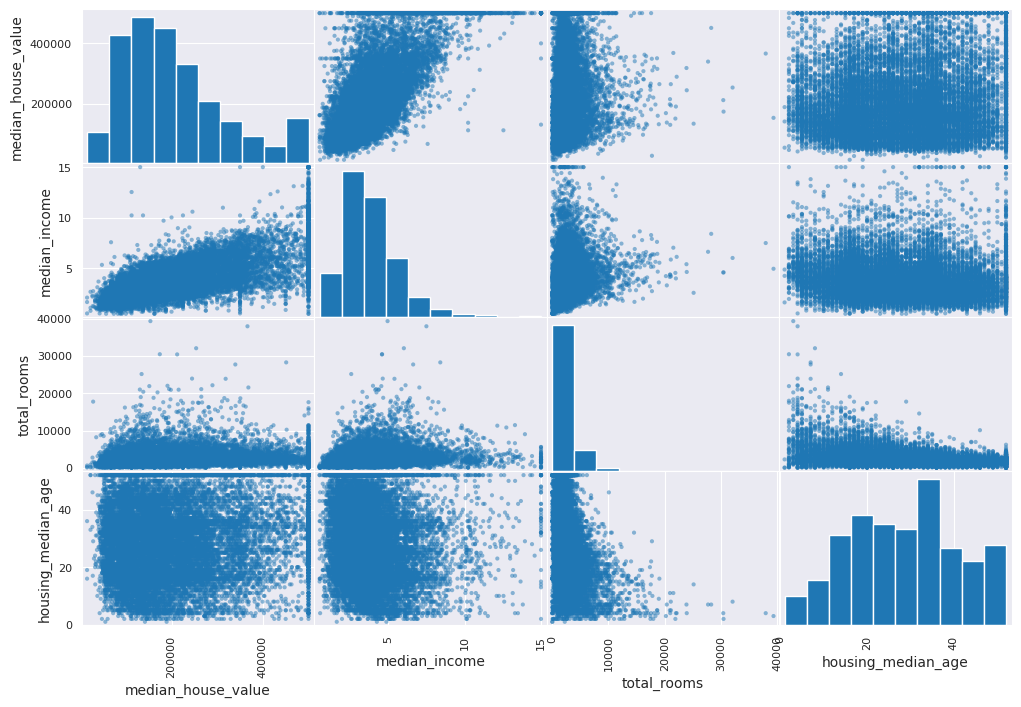

In [17]:
# scatter matrix
from pandas.plotting import scatter_matrix

attributes = ['median_house_value', 'median_income', 'total_rooms', 'housing_median_age']
scatter_matrix(housing[attributes], figsize=(12,8))

<Axes: xlabel='median_income', ylabel='median_house_value'>

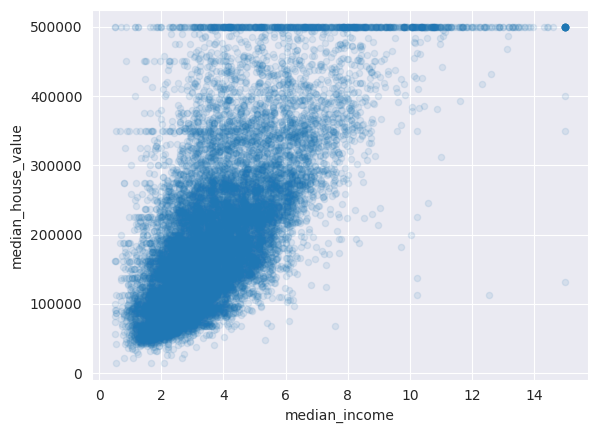

In [18]:
# median_house_value vs median_income

housing.plot(kind='scatter', x='median_income', y='median_house_value', alpha=0.1)

In [19]:
# feature engineering

housing['rooms_per_household'] = housing['total_rooms'] / housing['households'] # rooms per household
housing['bedrooms_per_room'] = housing['total_bedrooms'] / housing['total_rooms'] # bedrooms per room
housing['population_per_household'] = housing['population'] / housing['households'] # population per household

In [20]:
# correlation matrix with the newly added features
housing['ocean_proximity'] = housing['ocean_proximity'].astype('category').cat.codes
corr_matrix = housing.corr()
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687151
rooms_per_household         0.146255
total_rooms                 0.135140
housing_median_age          0.114146
ocean_proximity             0.076936
households                  0.064590
total_bedrooms              0.047781
population_per_household   -0.021991
population                 -0.026882
longitude                  -0.047466
latitude                   -0.142673
bedrooms_per_room          -0.259952
Name: median_house_value, dtype: float64

In [21]:
# data preparation

housing = strat_train_set.drop('median_house_value', axis=1)
housing_labels = strat_train_set['median_house_value'].copy()

In [22]:
# data cleaning

from sklearn.impute import SimpleImputer
import numpy.testing as npt

imputer = SimpleImputer(strategy='median')

housing_num = housing.drop('ocean_proximity', axis=1) # drop the non-numeric attribute

imputer.fit(housing_num) # fit the imputer instance to the training data

npt.assert_array_equal(imputer.statistics_, housing_num.median().values) # imputer statistics

In [23]:
# transform the training set by replacing missing values with the learned medians
X = imputer.transform(housing_num) # numpy array returns
housing_tr = pd.DataFrame(X, columns=housing_num.columns, index=housing_num.index) # convert to pandas dataframe

In [24]:
# handling text and categorical attributes

housing_cat = housing[['ocean_proximity']]
housing_cat.head(10)

,ocean_proximity
12655,INLAND
15502,NEAR OCEAN
2908,INLAND
14053,NEAR OCEAN
20496,<1H OCEAN
1481,NEAR BAY
18125,<1H OCEAN
5830,<1H OCEAN
17989,<1H OCEAN
4861,<1H OCEAN


In [25]:
# convert the text categories to numbers
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder

ordinal_encoder = OrdinalEncoder()

housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)
housing_cat_encoded[:10] # encoded categories
ordinal_encoder.categories_ # categories
# When categories are similar (e.g. 'good', 'average', 'bad'), ordinal encoding is useful, but when they are not, one-hot encoding is better !!!

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [26]:
# let's use one-hot encoding
one_hot_encoder = OneHotEncoder()

housing_cat_1hot = one_hot_encoder.fit_transform(housing_cat)
housing_cat_1hot.toarray() # one-hot encoded categories

array([[0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.]], shape=(16512, 5))

In [27]:
one_hot_encoder.categories_ # categories

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [28]:
# custom transformers

from sklearn.base import BaseEstimator, TransformerMixin

rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6 # column indices

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room=True):
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room: # add bedrooms_per_room if active
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
        else: # else return the original data
            return np.c_[X, rooms_per_household, population_per_household]

In [29]:
attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values) # add the new attributes
housing_extra_attribs

array([[-121.46, 38.52, 29.0, ..., 'INLAND', 5.485835694050992,
        3.168555240793201],
       [-117.23, 33.09, 7.0, ..., 'NEAR OCEAN', 6.927083333333333,
        2.6236979166666665],
       [-119.04, 35.37, 44.0, ..., 'INLAND', 5.3933333333333335,
        2.223333333333333],
       ...,
       [-122.72, 38.44, 48.0, ..., '<1H OCEAN', 4.1104651162790695,
        2.6627906976744184],
       [-122.7, 38.31, 14.0, ..., '<1H OCEAN', 6.297405189620759,
        2.411177644710579],
       [-122.14, 39.97, 27.0, ..., 'INLAND', 5.477157360406092,
        3.1725888324873095]], shape=(16512, 11), dtype=object)

In [ ]:
# transformation pipelines

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')), # imputer
    ('attribs_adder', CombinedAttributesAdder()), # add new attributes
    ('std_scaler', StandardScaler()) # standardize the data
])

In [ ]:
# create a full pipeline that handles both numerical and categorical attributes

from sklearn.compose import ColumnTransformer

num_attribs = list(housing_num)
cat_attribs = ['ocean_proximity']

full_pipeline = ColumnTransformer([
    ('num', num_pipeline, num_attribs), # numerical attributes
    ('cat', OneHotEncoder(), cat_attribs) # categorical attributes
])

housing_prepared = full_pipeline.fit_transform(housing) # transform the data

In [ ]:
# select model and train

from sklearn.linear_model import LinearRegression

lin_reg_model = LinearRegression()

lin_reg_model.fit(housing_prepared, housing_labels) # fit the model

# prediction
some_data = housing.iloc[:5] # select some data from the training set
some_labels = housing_labels.iloc[:5] # select some labels from the training set
some_data_prepared = full_pipeline.transform(some_data) # transform the data

In [ ]:
predicted_labels = lin_reg_model.predict(some_data_prepared) # predict
original_labels = list(some_labels) # original labels
diffs = predicted_labels - some_labels # differences between the predicted and original labels

print('Predicted labels:', predicted_labels)
print('Original labels:', original_labels)
print('Differences:', diffs)

In [ ]:
# measure model by using Mean Squared Error

from sklearn.metrics import mean_squared_error

housing_predictions = lin_reg_model.predict(housing_prepared) # predict the labels
lin_mse = mean_squared_error(housing_labels, housing_predictions) # calculate the mean squared error
lin_rmse = np.sqrt(lin_mse) # calculate the root mean squared error
lin_rmse # root mean squared error is 68.628 dollars per house

In [ ]:
# use DecisionTreeRegressor

from sklearn.tree import DecisionTreeRegressor

tree_reg_model = DecisionTreeRegressor()

tree_reg_model.fit(housing_prepared, housing_labels) # fit the model
housing_predictions = tree_reg_model.predict(housing_prepared) # predict the labels

tree_mse = mean_squared_error(housing_labels, housing_predictions) # calculate the mean squared error
tree_rmse = np.sqrt(tree_mse) # calculate the root mean squared error
tree_rmse # root mean squared error is 0 dollars per house ( overfitting, model works well on the training data but not on the test data)

In [ ]:
# using cross-validation

from sklearn.model_selection import cross_val_score

scores = cross_val_score(tree_reg_model, housing_prepared, housing_labels, # cross-validation
                            scoring='neg_mean_squared_error', cv=10)
tree_rmse_scores = np.sqrt(-scores) # root mean squared errors
print('Scores:', tree_rmse_scores)
print('Mean:', tree_rmse_scores.mean()) # mean of the root mean squared errors 71510 dollars per house (that's higher than the linear regression model)
print('Standard deviation:', tree_rmse_scores.std())

In [ ]:
# using cross-validation with the linear regression model

lin_scores = cross_val_score(lin_reg_model, housing_prepared, housing_labels, # cross-validation
                            scoring='neg_mean_squared_error', cv=10)
lin_rmse_scores = np.sqrt(-lin_scores) # root mean squared errors

print('Scores:', lin_rmse_scores)
print('Mean:', lin_rmse_scores.mean()) # mean of the root mean squared errors 69052 dollars per house
print('Standard deviation:', lin_rmse_scores.std())

In [ ]:
# using RandomForestRegressor

from sklearn.ensemble import RandomForestRegressor

forest_reg_model = RandomForestRegressor()

forest_reg_model.fit(housing_prepared, housing_labels) # fit the model

housing_predictions = forest_reg_model.predict(housing_prepared)
forest_mse = mean_squared_error(housing_labels, housing_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse # root mean squared error is 18655 dollars per house

In [39]:
forest_scores = cross_val_score(forest_reg_model, housing_prepared, housing_labels,
                                scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)

print('Scores:', forest_rmse_scores)
print('Mean:', forest_rmse_scores.mean()) # Mean value is 50.267 dollars per house
print('Standard deviation:', forest_rmse_scores.std()) # Standard deviation is 2.177 dollars

KeyboardInterrupt: 

In [ ]:
# If cross_val_score greater then mse of predicted data, it means overfitting
# If cross_val_score less then mse of predicted data, it means underfitting

In [ ]:
# save the model

import joblib

joblib.dump(forest_reg_model, 'forest_reg_model.pkl') # save the model

In [ ]:
# load the model

forest_reg_model_loaded = joblib.load('forest_reg_model.pkl') # load the model

In [ ]:
# fine-tuning the model

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

param_grid = [
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]}, # hyperparameters
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]} # hyperparameters
]

forest_reg_model = RandomForestRegressor()

grid_search = RandomizedSearchCV(forest_reg_model, param_grid, cv=5, # grid search
                            scoring='neg_mean_squared_error',
                            return_train_score=True, verbose=1, n_jobs=-1)    

grid_search.fit(housing_prepared, housing_labels) # fit the model

In [ ]:
best_params = grid_search.best_params_ # best hyperparameters
print('Best parameters:', best_params)
best_estimator = grid_search.best_estimator_ # best estimator

In [ ]:
# Best parameters: {'n_estimators': 30, 'max_features': 6}
# That's means n_estimators selected maximum value, so you can try to increase n_estimators

In [ ]:
param_grid = [
    {'n_estimators': [100, 150, 200, 300], 'max_features': [5, 6, 7], 'bootstrap': [False]}
]
grid_search = RandomizedSearchCV(forest_reg_model, param_grid, cv=5, # grid search
                            scoring='neg_mean_squared_error',
                            return_train_score=True, verbose=1, n_jobs=-1)    

grid_search.fit(housing_prepared, housing_labels) # fit the model

best_params = grid_search.best_params_ # best hyperparameters
print('Best parameters:', best_params)

In [ ]:
# analyzing the best models and their errors

feature_importances = best_estimator.feature_importances_ # feature importances
print('Feature importances:', feature_importances)

extra_attribs = ['rooms_per_hhold', 'pop_per_hhold', 'bedrooms_per_room'] # extra attributes
cat_encoder = full_pipeline.named_transformers_['cat'] # categorical encoder
cat_one_hot_attribs = list(cat_encoder.categories_[0]) # one-hot encoded categories
attributes = num_attribs + extra_attribs + cat_one_hot_attribs # attributes
sorted(zip(feature_importances, attributes), reverse=True) # sorted feature importances

In [ ]:
# evaluate the model on the test set

final_model = grid_search.best_estimator_ # best model

X_test = strat_test_set.drop('median_house_value', axis=1) # test set
y_test = strat_test_set['median_house_value'].copy() # test labels

X_test_prepared = full_pipeline.transform(X_test) # transform the test set
final_predictions = final_model.predict(X_test_prepared) # predict the labels

final_mse = mean_squared_error(y_test, final_predictions) # calculate the mean squared error
final_rmse = np.sqrt(final_mse) # calculate the root mean squared error
print('Root mean squared error:', final_rmse) # root mean squared error is 

In [ ]:
# confidence interval calculation

from scipy import stats

confidence = 0.95 # confidence level

squared_errors = (final_predictions - y_test) ** 2 # squared errors
np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1, # confidence interval
                        loc=squared_errors.mean(),
                        scale=stats.sem(squared_errors)))   # confidence interval

In [ ]:
# Question parts

In [ ]:
# 1. Use SVC with various hyperparameters

from sklearn.svm import SVR

param_grid = [
    {'kernel': ['linear'], 'C': [10., 30., 100., 300., 1000., 3000., 10000., 30000.]},
    {'kernel': ['rbf'], 'C': [1.0, 3.0, 10., 30., 100., 300., 1000.0],
     'gamma': [0.01, 0.03, 0.1, 0.3, 1.0, 3.0]}
]

svr_model = SVR()

grid_search = GridSearchCV(svr_model, param_grid, cv=5, # grid search
                            scoring='neg_mean_squared_error',
                            return_train_score=True, verbose=1, n_jobs=-1)

grid_search.fit(housing_prepared, housing_labels) # fit the model

best_params = grid_search.best_params_ # best hyperparameters
print('Best parameters:', best_params) # {'C': 30000.0, 'kernel': 'linear'}

In [ ]:
# 2. Replace GridSearchCV with RandomizedSearchCV
from scipy.stats import expon, reciprocal

# Note: gamma is ignored when kernel is "linear"
param_distribs = {
        'kernel': ['linear', 'rbf'],
        'C': reciprocal(20, 200000), # reciprocal distribution generator
        'gamma': expon(scale=1.0), # exponential distribution generator
    }

svr_model = SVR()

randomized_search = RandomizedSearchCV(svr_model, param_grid, cv=5, # randomized search
                                       n_iter=50, random_state=42,
                                       scoring='neg_mean_squared_error',
                                       return_train_score=True, verbose=1, n_jobs=-1)  

negative_mse = randomized_search.best_score_
rmse = np.sqrt(-negative_mse)
rmse
# {'C': 157055.10989448498, 'gamma': 0.26497040005002437, 'kernel': 'rbf'}

In [ ]:
# Question: Try adding a transformer in the preparation pipeline to select only the most important attributes.

from sklearn.base import BaseEstimator, TransformerMixin

def indices_of_top_k(arr, k):
    """
    Return the indices of the top k elements of an array
    """
    return np.sort(np.argpartition(np.array(arr), -k)[-k:])

class TopFeatureSelector(BaseEstimator, TransformerMixin):
    """
    Select the top k features based on the feature importances
    """
    def __init__(self, feature_importances, k: int):
        self.feature_importances = feature_importances
        self.k = k
    def fit(self, X, y=None):
        """
        Fit the transformer
        """
        self.feature_indices_ = indices_of_top_k(self.feature_importances, self.k)
        return self
    def transform(self, X):
        """
        Transform the data
        """
        return X[:, self.feature_indices_]
    
k = 5 # number of top features
top_k_feature_indices = indices_of_top_k(feature_importances, k) # top k feature indices

preparation_and_feature_selection_pipeline = Pipeline([
    ('preparation', full_pipeline),
    ('feature_selection', TopFeatureSelector(feature_importances, k))
])

housing_prepared_top_k_features = preparation_and_feature_selection_pipeline.fit_transform(housing) # transform the data

In [ ]:
# Question: Try creating a single pipeline that does the full data preparation plus the final prediction.

prepare_select_and_predict_pipeline = Pipeline([
    ('preparation', full_pipeline),
    ('feature_selection', TopFeatureSelector(feature_importances, k)),
    ('prediction', final_model)
])

prepare_select_and_predict_pipeline.fit(housing, housing_labels) # fit the model

In [ ]:
# Question: Automatically explore some preparation options using GridSearchCV.

param_grid = [{
    'preparation__num__imputer__strategy': ['mean', 'median', 'most_frequent'], # imputer strategies
    'feature_selection__k': list(range(1, len(feature_importances) + 1)) # number of top features (1 to max number of features)
}]

grid_search_prep = GridSearchCV(prepare_select_and_predict_pipeline, param_grid, cv=5,
                                scoring='neg_mean_squared_error', verbose=2, n_jobs=-1)

grid_search_prep.fit(housing, housing_labels) # fit the model

grid_search_prep.best_params_ # best parameters {'feature_selection__k': 15,  'preparation__num__imputer__strategy': 'most_frequent'}